In [169]:
# Libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


# Metrics
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error, mean_absolute_error




***IMPORT DATA***

In [170]:
# read the data
df = pd.read_csv('marketing_campaign_dataset_training_20K.csv')

# filter for first 10K rows

filtered_df = df.iloc[:10000,:]



/var/folders/f7/dl42drj92qg78wp87m730h3m0000gn/T/ipykernel_60411/1861291050.py:2: DtypeWarning: Columns (1,2,3,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('marketing_campaign_dataset_training_20K.csv')


In [171]:
# show which "customer_segments" and "target_audiences" are in the dataset
print(df['customer_segment'].unique())
print(df['target_audience'].unique())


['Health & Wellness' 'Fashionistas' 'Outdoor Adventurers' 'Foodies'
 'Tech Enthusiasts' nan]
['Men 18-24' 'Women 35-44' 'Men 25-34' 'All Ages' 'Women 25-34' nan]


***INITIAL DATA EXPLORATION***

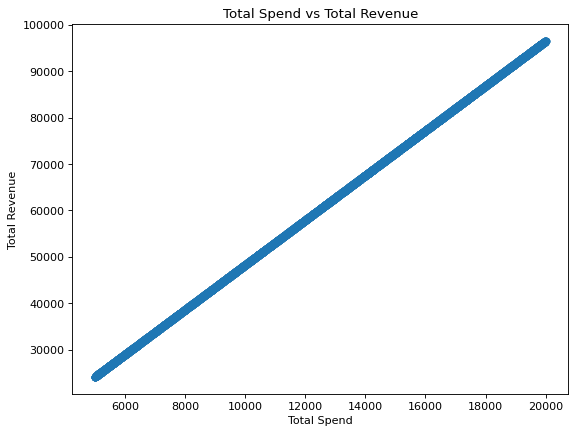

In [172]:
# plot total spend vs total revenue

figure(figsize=(8, 6), dpi=80)

plt.scatter(filtered_df['spend_total'], filtered_df['revenue_total'])
plt.title('Total Spend vs Total Revenue')
plt.xlabel('Total Spend')
plt.ylabel('Total Revenue')
plt.show()


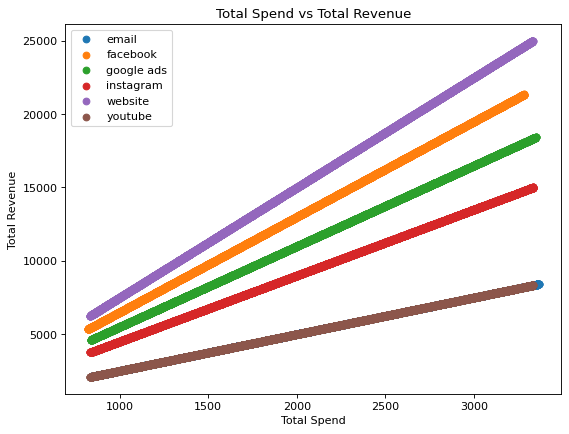

In [173]:
# Plot total spend vs total revenue for each channel

figure(figsize=(8, 6), dpi=80)

plt.scatter(filtered_df['spend_email'], filtered_df['revenue_email'], label='email')
plt.scatter(filtered_df['spend_facebook'], filtered_df['revenue_facebook'], label='facebook')
plt.scatter(filtered_df['spend_google_ads'], filtered_df['revenue_google_ads'], label='google ads')
plt.scatter(filtered_df['spend_instagram'], filtered_df['revenue_instagram'], label='instagram')
plt.scatter(filtered_df['spend_website'], filtered_df['revenue_website'], label='website')
plt.scatter(filtered_df['spend_youtube'], filtered_df['revenue_youtube'], label='youtube')
plt.title('Total Spend vs Total Revenue')
plt.xlabel('Total Spend')
plt.ylabel('Total Revenue')
plt.legend()
plt.show()


***DATA PRE-PROCESSING***

In [174]:
# define dependent variables

y = filtered_df[['revenue_email', 'revenue_facebook', 'revenue_google_ads', 'revenue_instagram', 
        'revenue_website', 'revenue_youtube']]

In [175]:
# define the features (independent variables) as X
X = filtered_df.drop(['revenue_email', 'revenue_facebook', 'revenue_google_ads', 'revenue_instagram', 
        'revenue_website', 'revenue_youtube', 'revenue_total','impressions','clicks','id','name', 'spend_total', 'end_date'], axis=1)

X

,start_date,duration,customer_segment,target_audience,spend_email,spend_facebook,spend_google_ads,spend_instagram,spend_website,spend_youtube
0,1/1/2023,30.0,Health & Wellness,Men 18-24,2722.0,2655.0,2709.0,2698.0,2694.0,2695.0
1,1/2/2023,60.0,Fashionistas,Women 35-44,1946.0,1899.0,1937.0,1929.0,1927.0,1928.0
2,1/3/2023,30.0,Outdoor Adventurers,Men 25-34,1717.0,1675.0,1709.0,1701.0,1699.0,1700.0
3,1/4/2023,60.0,Health & Wellness,All Ages,2141.0,2089.0,2131.0,2122.0,2120.0,2120.0
4,1/5/2023,15.0,Health & Wellness,Men 25-34,2769.0,2701.0,2756.0,2744.0,2741.0,2742.0
...,...,...,...,...,...,...,...,...,...,...
9995,5/21/2023,15.0,Foodies,Women 25-34,2707.0,2641.0,2694.0,2683.0,2679.0,2680.0
9996,5/22/2023,30.0,Outdoor Adventurers,Men 18-24,1280.0,1249.0,1274.0,1268.0,1267.0,1267.0
9997,5/23/2023,60.0,Health & Wellness,All Ages,2158.0,2105.0,2148.0,2138.0,2136.0,2137.0
9998,5/24/2023,15.0,Health & Wellness,All Ages,2618.0,2554.0,2606.0,2595.0,2591.0,2593.0


In [176]:
# convert date column to datetime format

X['start_date'] = pd.to_datetime(X['start_date'])
X['year'] = X['start_date'].dt.year
X['month'] = X['start_date'].dt.month
X['day'] = X['start_date'].dt.day

# Drop the original date column
X = X.drop('start_date', axis=1)

In [177]:
# Handling missing values with SimpleImputer

# Split the data into numerical and categorical columns

# numerical columns
X_num = [col for col in X.columns if X[col].dtype in ['int64', 'float64', 'int32', 'float32', 'int16', 'float16', 'int8', 'float8', 'uint8', 'uint16', 'uint32', 'uint64', 'int', 'float', 'uint']]

# categorical columns
X_cat = [col for col in X.columns if X[col].dtype == 'object']

# define the imputer
imputer = SimpleImputer(strategy='median')

# fit the imputer to the numerical columns
imputer.fit(X[X_num])

# transform the numerical columns
X_num_imputed = imputer.transform(X[X_num])

# convert the array back to a dataframe
X_num_imputed = pd.DataFrame(X_num_imputed, columns=X_num)

# check for missing values
X_num_imputed.isna().sum()

# define the imputer
imputer = SimpleImputer(strategy='most_frequent')

# fit the imputer to the categorical columns
imputer.fit(X[X_cat])

# transform the categorical columns
X_cat_imputed = imputer.transform(X[X_cat])

# convert the array back to a dataframe
X_cat_imputed = pd.DataFrame(X_cat_imputed, columns=X_cat)

# check for missing values
X_cat_imputed.isna().sum()

# combine the numerical and categorical columns
X = pd.concat([X_num_imputed, X_cat_imputed], axis=1)

# check for missing values
X.isna().sum()



duration            0
spend_email         0
spend_facebook      0
spend_google_ads    0
spend_instagram     0
spend_website       0
spend_youtube       0
year                0
month               0
day                 0
customer_segment    0
target_audience     0
dtype: int64

In [178]:
# show how many of each customer_segment and target_audience are in the dataset
print(X['customer_segment'].value_counts())
print(X['target_audience'].value_counts())


customer_segment
Foodies                2096
Tech Enthusiasts       2031
Health & Wellness      1986
Fashionistas           1967
Outdoor Adventurers    1920
Name: count, dtype: int64
target_audience
Men 25-34      2041
Men 18-24      2016
All Ages       2001
Women 25-34    1974
Women 35-44    1968
Name: count, dtype: int64


In [179]:
# # Convert Acquisition_Cost column from $ to float
# filtered_df['Acquisition_Cost'] = filtered_df['Acquisition_Cost'].str.replace('$', '').str.replace(',', '').astype(float)
# # Split the string on space and take the first part (the number), then convert to integer
# filtered_df['Duration'] = filtered_df['Duration'].str.split().str[0].astype(int)

In [180]:
# convert categorical variables to dummy variables

X = pd.get_dummies(X)


In [181]:
X.head()

,duration,spend_email,spend_facebook,spend_google_ads,spend_instagram,spend_website,spend_youtube,year,month,day,customer_segment_Fashionistas,customer_segment_Foodies,customer_segment_Health & Wellness,customer_segment_Outdoor Adventurers,customer_segment_Tech Enthusiasts,target_audience_All Ages,target_audience_Men 18-24,target_audience_Men 25-34,target_audience_Women 25-34,target_audience_Women 35-44
0,30.0,2722.0,2655.0,2709.0,2698.0,2694.0,2695.0,2023.0,1.0,1.0,False,False,True,False,False,False,True,False,False,False
1,60.0,1946.0,1899.0,1937.0,1929.0,1927.0,1928.0,2023.0,1.0,2.0,True,False,False,False,False,False,False,False,False,True
2,30.0,1717.0,1675.0,1709.0,1701.0,1699.0,1700.0,2023.0,1.0,3.0,False,False,False,True,False,False,False,True,False,False
3,60.0,2141.0,2089.0,2131.0,2122.0,2120.0,2120.0,2023.0,1.0,4.0,False,False,True,False,False,True,False,False,False,False
4,15.0,2769.0,2701.0,2756.0,2744.0,2741.0,2742.0,2023.0,1.0,5.0,False,False,True,False,False,False,False,True,False,False


In [182]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [183]:
# Scale the data

scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

# transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# transform the testing dat
X_test_scaled = scaler.transform(X_test)



***SETUP TRAINING CONDITIONS AND INSTANTIATE MODELS***

In [184]:
# Instaniate K Fold cross validation

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create params space for RandomizedSearchCV to search over for RandomForestRegressor

params_random_forest = {
    'estimator__n_estimators': [100, 200, 300, 400, 500],
    'estimator__max_depth': [None, 1, 2, 3, 4, 5],
    'estimator__min_samples_split': [2, 3, 4, 5],
    'estimator__min_samples_leaf': [1, 2, 3, 4, 5],
    'estimator__max_features': ['auto', 'sqrt', 'log2']
}


# Create params space for RandomizedSearchCV to search over for Lasso and Ridge models

params_lasso = {
    'estimator__alpha': [0.01, 0.1, 1, 10, 100, 1000]
}

params_ridge = {
    'estimator__alpha': [0.01, 0.1, 1, 10, 100, 1000],
    'estimator__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}




In [185]:
# Instantiate the RandomizedSearchCV objects for all models with multiple output regression
random_forecast_cv = RandomizedSearchCV(MultiOutputRegressor(RandomForestRegressor()), params_random_forest, cv=kf, n_iter=10, n_jobs=-1)
lasso_cv = RandomizedSearchCV(MultiOutputRegressor(Lasso()), params_lasso, cv=kf, n_iter=10, n_jobs=-1)
ridge_cv = RandomizedSearchCV(MultiOutputRegressor(Ridge()), params_ridge, cv=kf, n_iter=10, n_jobs=-1)

# Instantiate Linear Regression model
linear_regression = MultiOutputRegressor(LinearRegression())


***FIT AND EVALUATE THE MODELS***

In [186]:
# Fit Random Forest, Lasso, and Ridge models on training data

random_forecast_cv.fit(X_train_scaled, y_train)
lasso_cv.fit(X_train_scaled, y_train)
ridge_cv.fit(X_train_scaled, y_train)
linear_regression.fit(X_train_scaled, y_train)


/Users/justinchung/Coding/Springboard_Bootcamp/capstone_2/marketing_planner_app/backend/venvcapstone2/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/justinchung/Coding/Springboard_Bootcamp/capstone_2/marketing_planner_app/backend/venvcapstone2/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/justinchung/Coding/Springboard_Bootcamp/capstone_2/marketing_planner_app/backend/venvcapstone2/lib/python3.10/site-packa

MultiOutputRegressor(estimator=LinearRegression())

In [187]:
# Get the best estimators

best_rf = random_forecast_cv.best_estimator_
best_lasso = lasso_cv.best_estimator_
best_ridge = ridge_cv.best_estimator_


In [188]:
# Evaluate the models Using cross_val_score

# Random Forest
random_forecast_cv_score = cross_val_score(best_rf, X_train_scaled, y_train, cv=kf, n_jobs=-1)

# Lasso
lasso_cv_score = cross_val_score(best_lasso, X_train_scaled, y_train, cv=kf, n_jobs=-1)

# Ridge
ridge_cv_score = cross_val_score(best_ridge, X_train_scaled, y_train, cv=kf, n_jobs=-1)

# Linear Regression
linear_regression_score = cross_val_score(linear_regression, X_train_scaled, y_train, cv=kf, n_jobs=-1)



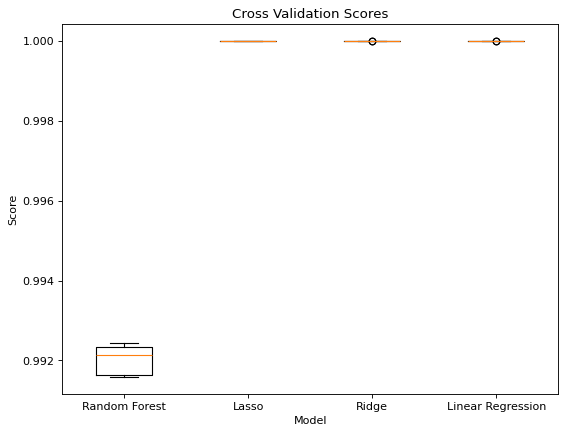

In [189]:
# Plot the scores on boxplots

figure(figsize=(8, 6), dpi=80)

plt.boxplot([random_forecast_cv_score, lasso_cv_score, ridge_cv_score, linear_regression_score], labels=['Random Forest', 'Lasso', 'Ridge', 'Linear Regression'])
plt.title('Cross Validation Scores')
plt.xlabel('Model')
plt.ylabel('Score')
plt.show()


***MAKE PREDICTIONS***

In [190]:
# Make predictions on test data

random_forecast_cv_pred = random_forecast_cv.predict(X_test_scaled)
lasso_cv_pred = lasso_cv.predict(X_test_scaled)
ridge_cv_pred = ridge_cv.predict(X_test_scaled)
linear_regression_pred = linear_regression.predict(X_test_scaled)


***MEASURE MODEL PERFORMANCE***

In [191]:
# Print the tuned parameters and score for the best model for each model

# print('********************** Linear Regression R2 Score **********************')
# print("Liner Regression Cross Validated Score: {}".format(cross_val_score(linear_regression, X_train, y_train, cv=kf).mean()))  

# print('********************** Random Forest Best Params & R2 Score **********************')
# print("Tuned Random Forest Parameters: {}".format(random_forecast_cv.best_params_))
# print("Tuned Random Forest Best Accuracy Score: {}".format(random_forecast_cv.best_score_))

# print('********************** Lasso Best Params & R2 Score **********************')
# print("Tuned Lasso Parameters: {}".format(lasso_cv.best_params_))
# print("Tuned Lasso Best Accuracy Score: {}".format(lasso_cv.best_score_))

# print('********************** Ridge Best Params & R2 Score **********************')
# print("Tuned Ridge Parameters: {}".format(ridge_cv.best_params_))
# print("Tuned Ridge Best Accuracy Score: {}".format(ridge_cv.best_score_))

In [192]:
# Measure the performance of the models with the test data

# R2 score is the proportion of the variance in the dependent variable that is predictable from the independent variable(s)

print('****************** R2 Score ******************')
print('Linear Regression R2:', linear_regression.score(X_test_scaled, y_test))
print('Random Forest R2:', random_forecast_cv.score(X_test_scaled, y_test))
print('Lasso R2:', lasso_cv.score(X_test_scaled, y_test))
print('Ridge R2:', ridge_cv.score(X_test_scaled, y_test))


# Mean Squared Error (MSE) is the mean of the squared errors. It’s more popular than MAE because MSE "punishes" larger errors, which tends to be useful in the real world.
print('****************** MSE ******************')
print('Linear Regression MSE:', mean_squared_error(y_test, linear_regression_pred))
print('Random Forest MSE:', mean_squared_error(y_test, random_forecast_cv_pred))
print('Lasso MSE:', mean_squared_error(y_test, lasso_cv_pred))
print('Ridge MSE:', mean_squared_error(y_test, ridge_cv_pred))


# # Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:
print('****************** RMSE ******************')
print('Linear Regression RMSE:', mean_squared_error(y_test, linear_regression_pred, squared=False))
print('Random Forest RMSE:', mean_squared_error(y_test, random_forecast_cv_pred, squared=False))
print('Lasso RMSE:', mean_squared_error(y_test, lasso_cv_pred, squared=False))
print('Ridge RMSE:', mean_squared_error(y_test, ridge_cv_pred, squared=False))





****************** R2 Score ******************
Linear Regression R2: 0.9999999635643229
Random Forest R2: 0.9922014087616725
Lasso R2: 0.9999998365810954
Ridge R2: 0.9999999634989368
****************** MSE ******************
Linear Regression MSE: 0.4454966423088383
Random Forest MSE: 113074.42405890256
Lasso MSE: 2.2823771590300326
Ridge MSE: 0.4458283749067861
****************** RMSE ******************
Linear Regression RMSE: 0.6404079103633878
Random Forest RMSE: 313.5095689152783
Lasso RMSE: 1.4183749410051447
Ridge RMSE: 0.6407397886959475


***VISUALIZE COEFFICIENTS AND FEATURE IMPORTANCE***

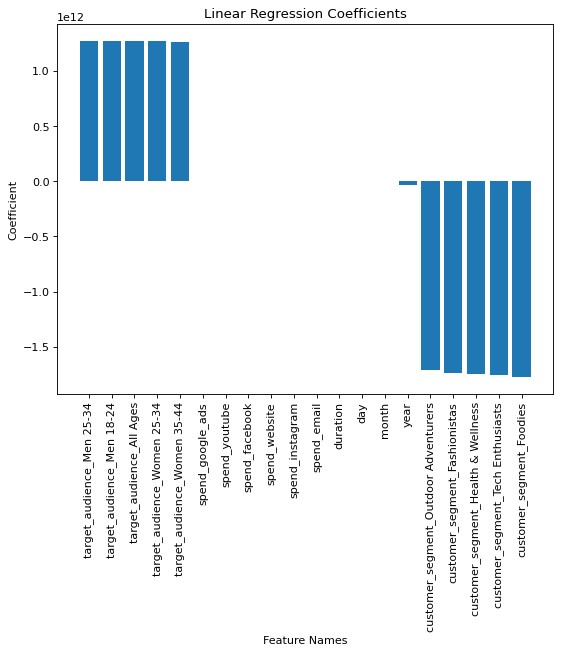

In [193]:
# Graph Coefficients from Linear Regression Models

# Get coefficients from linear regression model
linear_regression_coef = linear_regression.estimators_[0].coef_

# Get feature names from X_train
feature_names = X_train.columns

# Create a dataframe of coefficients and their feature names
linear_regression_coef_df = pd.DataFrame({'feature_names': feature_names, 'coef': linear_regression_coef})

# Sort the dataframe by coefficient value
linear_regression_coef_df = linear_regression_coef_df.sort_values('coef', ascending=False)

# Plot the coefficients
figure(figsize=(8, 6), dpi=80)
plt.bar(linear_regression_coef_df['feature_names'], linear_regression_coef_df['coef'])
plt.xticks(rotation=90)
plt.title('Linear Regression Coefficients')
plt.xlabel('Feature Names')
plt.ylabel('Coefficient')
plt.show()





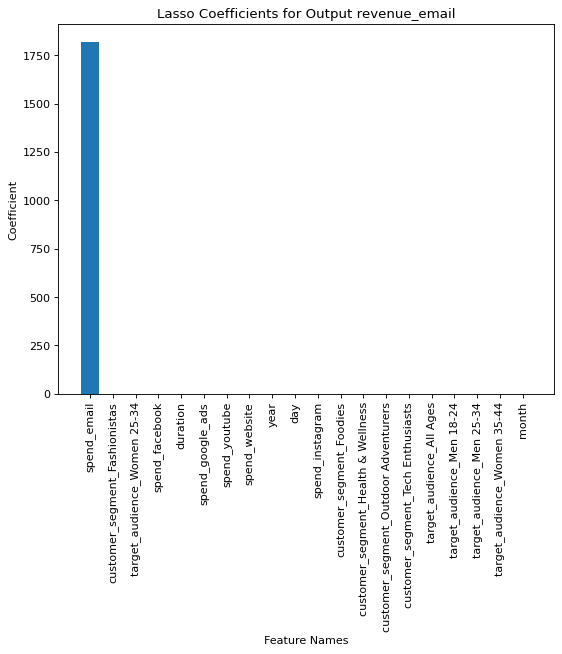

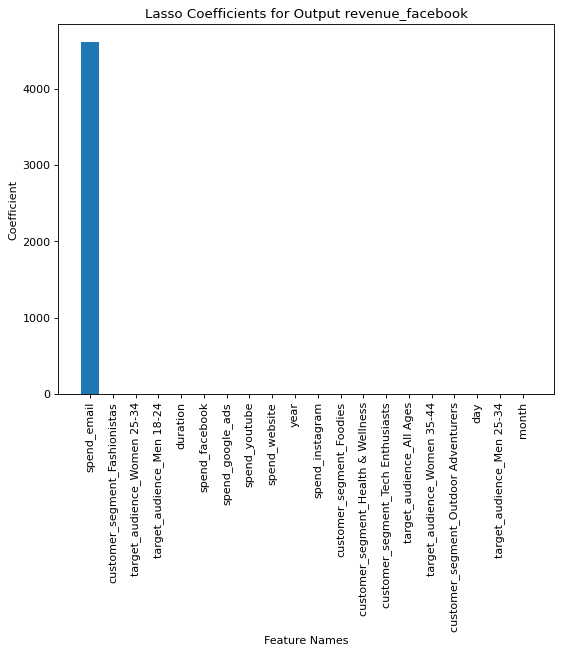

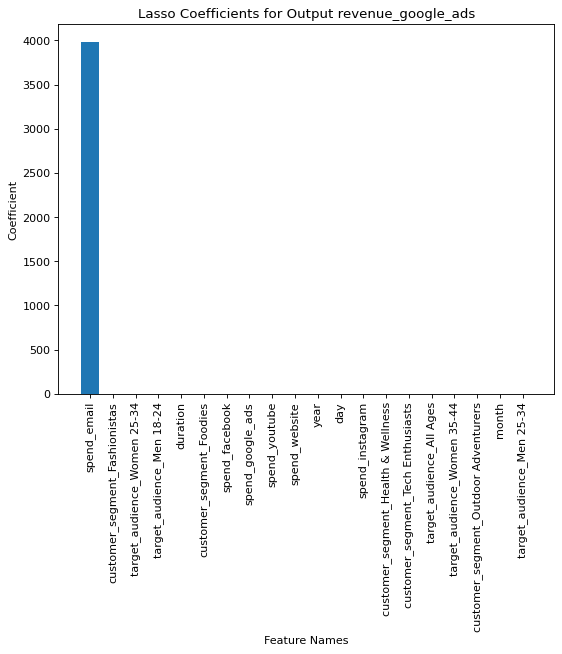

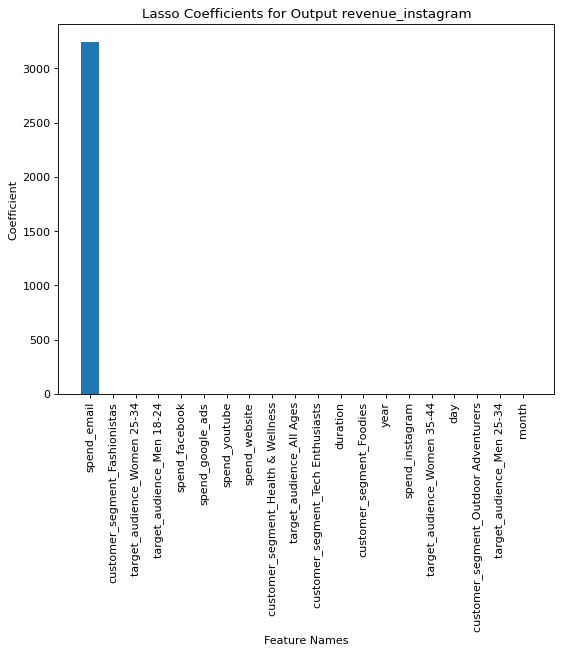

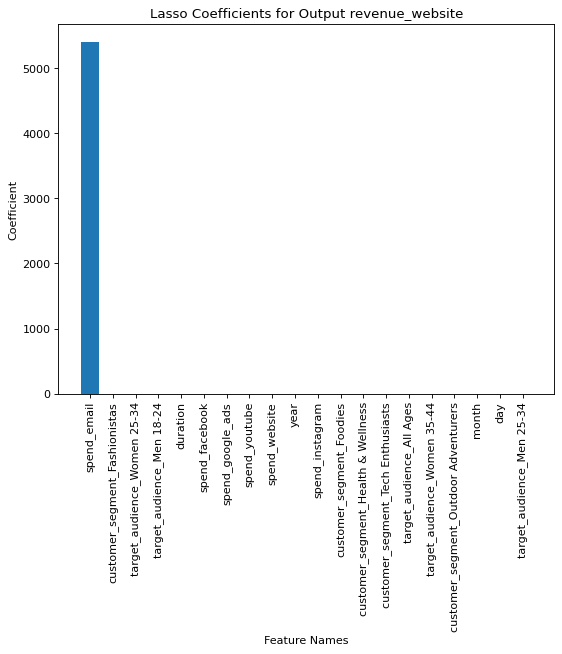

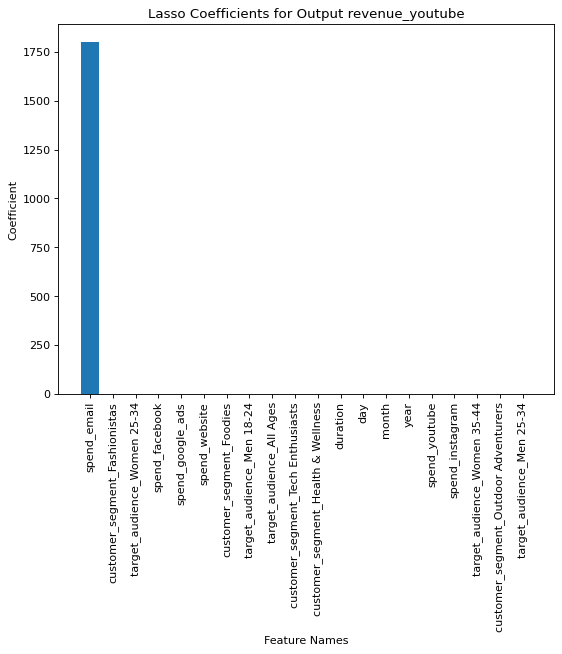

In [194]:
# Graph Coefficients from Lasso Models

# Assuming X_train is your training data
feature_names = X_train.columns

# Access the best multi-output estimator
best_lasso = lasso_cv.best_estimator_

# Dependet variable names
dependent_variables = y.columns

# Loop through each estimator to get coefficients
for i, estimator in enumerate(best_lasso.estimators_):
    lasso_coef = estimator.coef_
    lasso_coef_df = pd.DataFrame({'feature_names': feature_names, 'coef': lasso_coef})
    lasso_coef_df = lasso_coef_df.sort_values('coef', ascending=False)

    # Plot the coefficients for each output
    figure(figsize=(8, 6), dpi=80)
    plt.bar(lasso_coef_df['feature_names'], lasso_coef_df['coef'])
    plt.xticks(rotation=90)
    plt.title(f'Lasso Coefficients for Output {dependent_variables[i]}')
    plt.xlabel('Feature Names')
    plt.ylabel('Coefficient')
    plt.show()


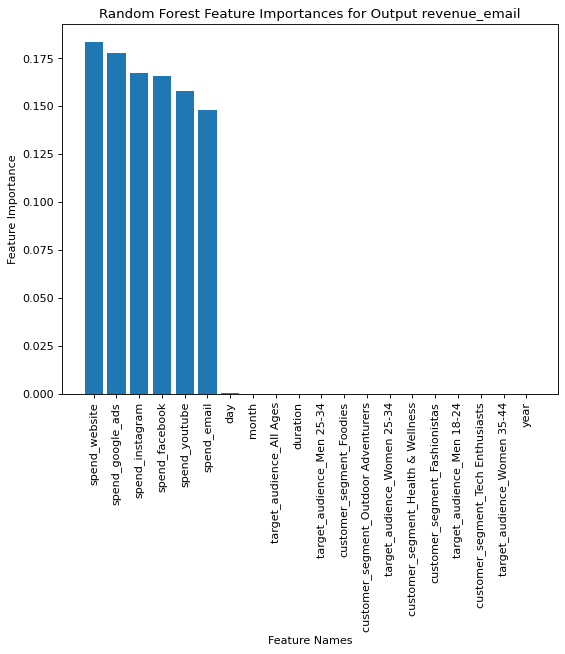

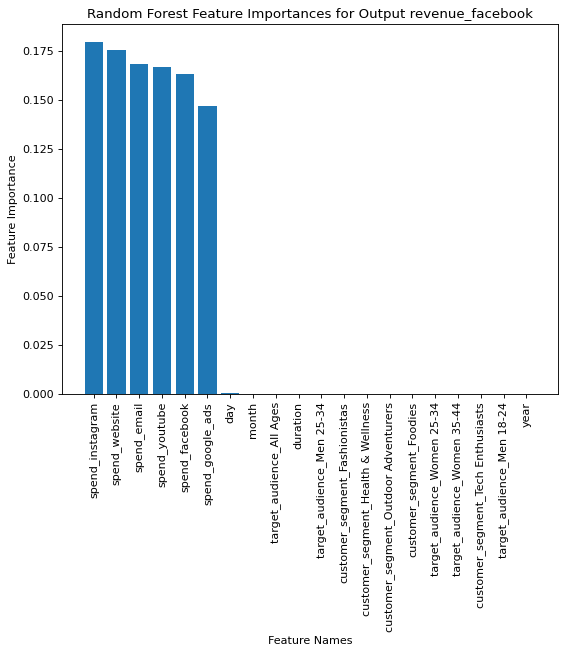

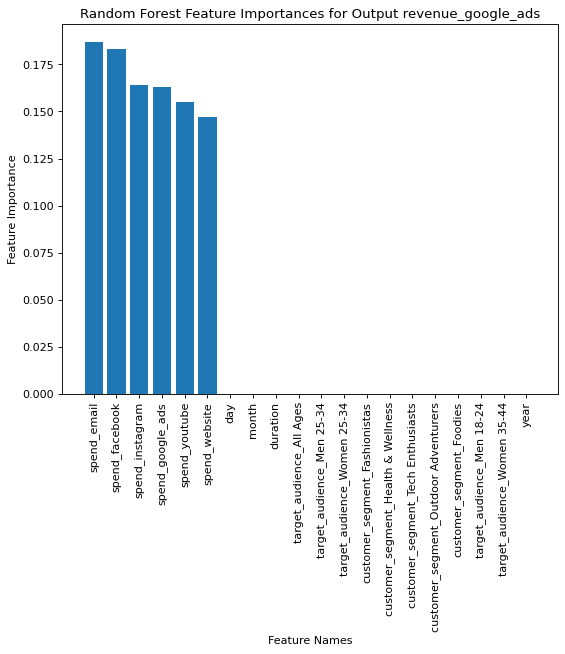

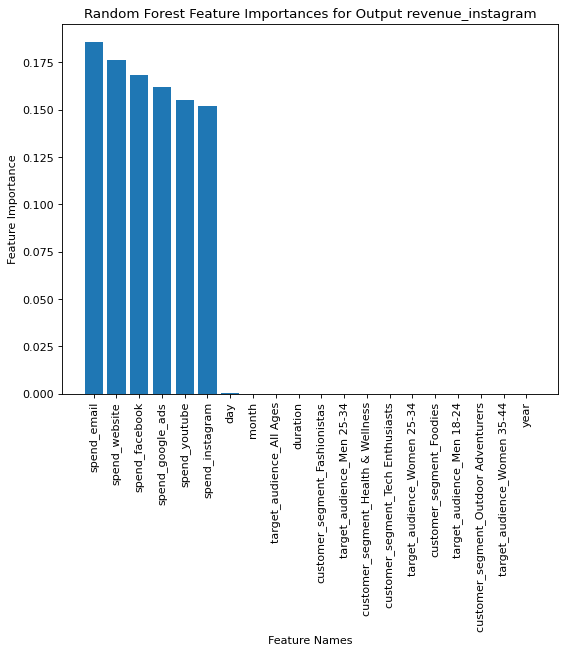

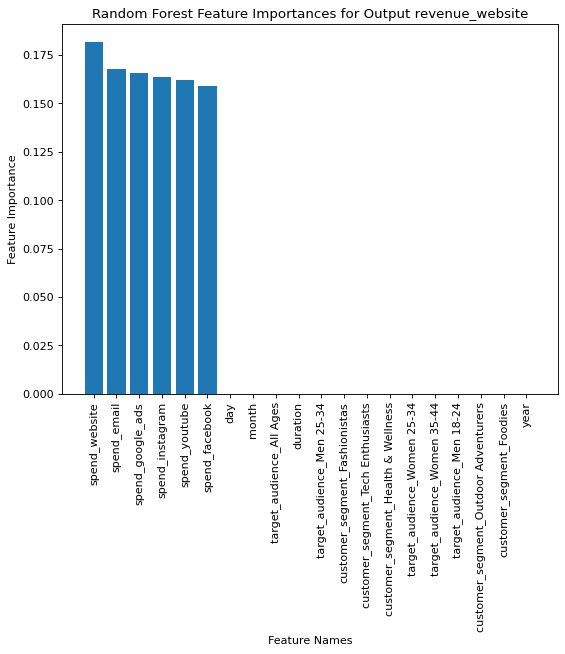

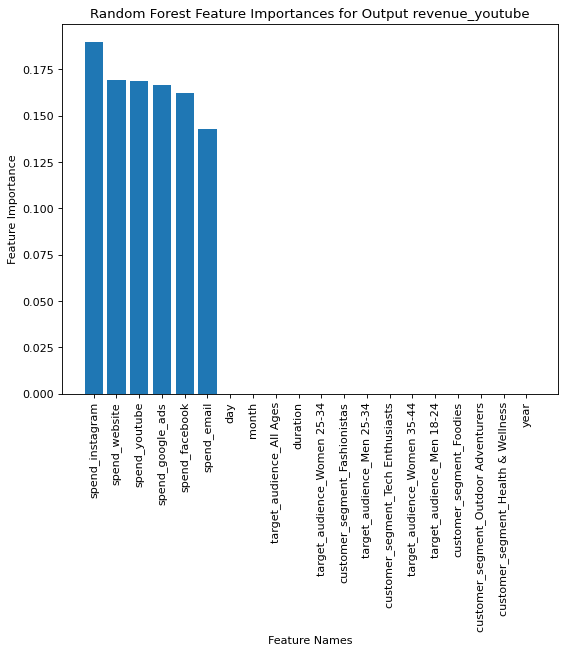

In [195]:
# Graph Feature Importances from Random Forest Models

# Assuming X_train is your training data
feature_names = X_train.columns

# Access the best multi-output estimator
best_random_forest = random_forecast_cv.best_estimator_

# Dependet variable names
dependent_variables = y.columns

# Loop through each estimator to get feature importances
for i, estimator in enumerate(best_random_forest.estimators_):
    random_forest_feature_importances = estimator.feature_importances_
    random_forest_feature_importances_df = pd.DataFrame({'feature_names': feature_names, 'feature_importances': random_forest_feature_importances})
    random_forest_feature_importances_df = random_forest_feature_importances_df.sort_values('feature_importances', ascending=False)

    # Plot the feature importances for each output
    figure(figsize=(8, 6), dpi=80)
    plt.bar(random_forest_feature_importances_df['feature_names'], random_forest_feature_importances_df['feature_importances'])
    plt.xticks(rotation=90)
    plt.title(f'Random Forest Feature Importances for Output {dependent_variables[i]}')
    plt.xlabel('Feature Names')
    plt.ylabel('Feature Importance')
    plt.show()

***SAVE MODELS TO DISK***

In [196]:
#Save the models to disk

rf_filename = 'marketing_planner_random_forest_model.sav'
lr_filename = 'marketing_planner_linear_regression_model.sav'
lasso_filename = 'marketing_planner_lasso_model.sav'
ridge_filename = 'marketing_planner_ridge_model.sav'


# RF model is over 2GB, so I'm not saving it
# pickle.dump(random_forecast_cv, open(rf_filename, 'wb'))
pickle.dump(linear_regression, open(lr_filename, 'wb'))
pickle.dump(lasso_cv, open(lasso_filename, 'wb'))
pickle.dump(ridge_cv, open(ridge_filename, 'wb'))

